## Important info about some parts of the code :

- grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)
    
    - estimator=model: This is the model you're optimizing (in this case, the Random Forest classifier).
    - param_grid=param_grid: This is the grid of parameters to search over.
    - cv=cv: This specifies the cross-validation strategy (the StratifiedKFold we just created).
    - n_jobs=-1: This tells the process to use all available CPU cores, speeding up the search.
    - scoring='accuracy': This specifies that we want to use accuracy as our evaluation metric.
    - verbose=2: This sets the verbosity level, controlling the amount of output during the process.

- rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, oob_score=True))
])

   - Δημιουργώ έναν αγωνγό επεξεργασίας και εκαπαίδευσης του Random Forest όπου τα δεδομένα περνούν διαδοχικά από διάφορα βήματα επεξεργασίας και εκπαίδευσης . Το πλεονέκτημα της χρήσης ενός Pipeline είναι ότι διασφαλίζει ότι οι ίδιοι μετασχηματισμοί (στην προκειμένη περίπτωση, η κλιμάκωση) εφαρμόζονται με συνέπεια τόσο στα δεδομένα εκπαίδευσης όσο και στα δεδομένα δοκιμής. 
   
   Επιτρέπει επίσης την προεπεξεργασία και το μοντέλο ως έναν ενιαίο εκτιμητή, κάτι που είναι ιδιαίτερα χρήσιμο στη διασταυρούμενη επικύρωση και την αναζήτηση πλέγματος. Ο RandomForestClassifier αρχικοποιείται με random_state=42 για λόγους αναπαραγωγιμότητας και oob_score=True για τον υπολογισμό του out-of-bag score, το οποίο είναι ένας τρόπος για να λάβετε μια αμερόληπτη εκτίμηση της απόδοσης του μοντέλου χωρίς να χρειάζεστε ένα ξεχωριστό σύνολο επικύρωσης.

- Output : for this line : " print(classification_report(y_test , y_pred) " 
    Δείχνει τις κύριες μετρικές ταξινόμησης για κάθε κλάση - συναίσθημα 


 

Performing Randomized Search for Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for Random Forest: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 35, 'class_weight': 'balanced', 'bootstrap': False}
Best cross-validation score for Random Forest: 0.4349550449550449

Test Set Results:
Balanced Accuracy: 0.4607
Accuracy: 0.4590
Log-loss: 2.4513
F1-score: 0.4489

Classification Report:
Abundant:
  Precision: 0.67
  Recall: 0.46
  F1-score: 0.55
  Support: 13

Active:
  Precision: 0.57
  Recall: 0.29
  F1-score: 0.38
  Support: 14

Adult:
  Precision: 0.44
  Recall: 0.31
  F1-score: 0.36
  Support: 13

Agile:
  Precision: 0.18
  Recall: 0.14
  F1-score: 0.16
  Support: 14

Alluring:
  Precision: 0.47
  Recall: 0.54
  F1-score: 0.50
  Support: 13

Amiable:
  Precision: 0.44
  Recall: 0.50
  F1-score: 0.47
  Support: 14

Amusing:
  Precision: 0.62
  Recall: 0.38

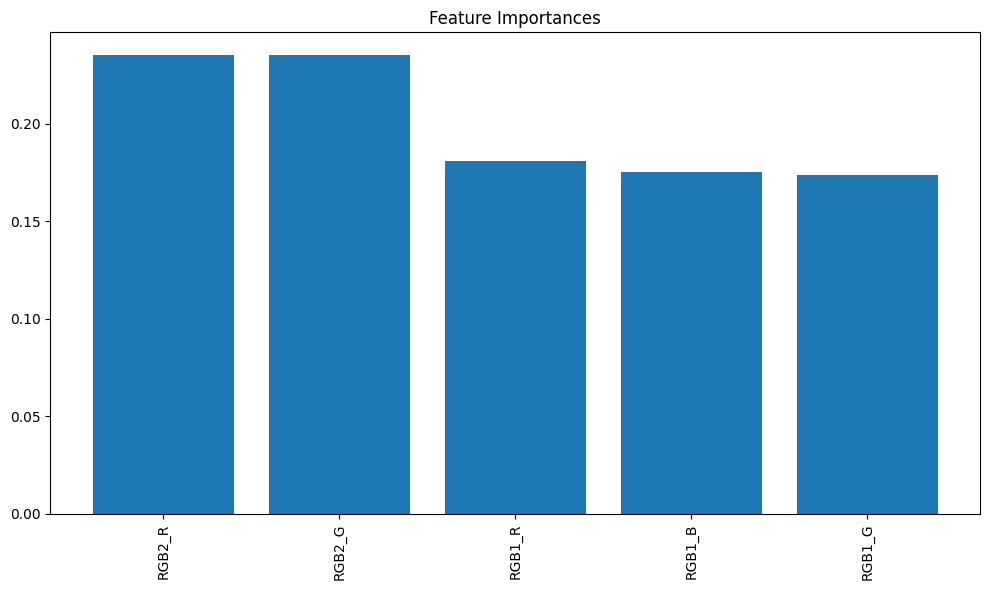

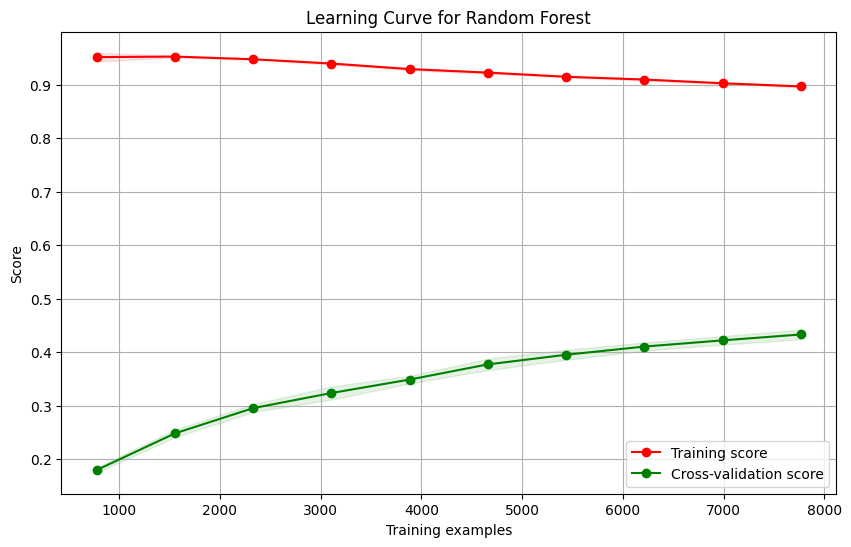

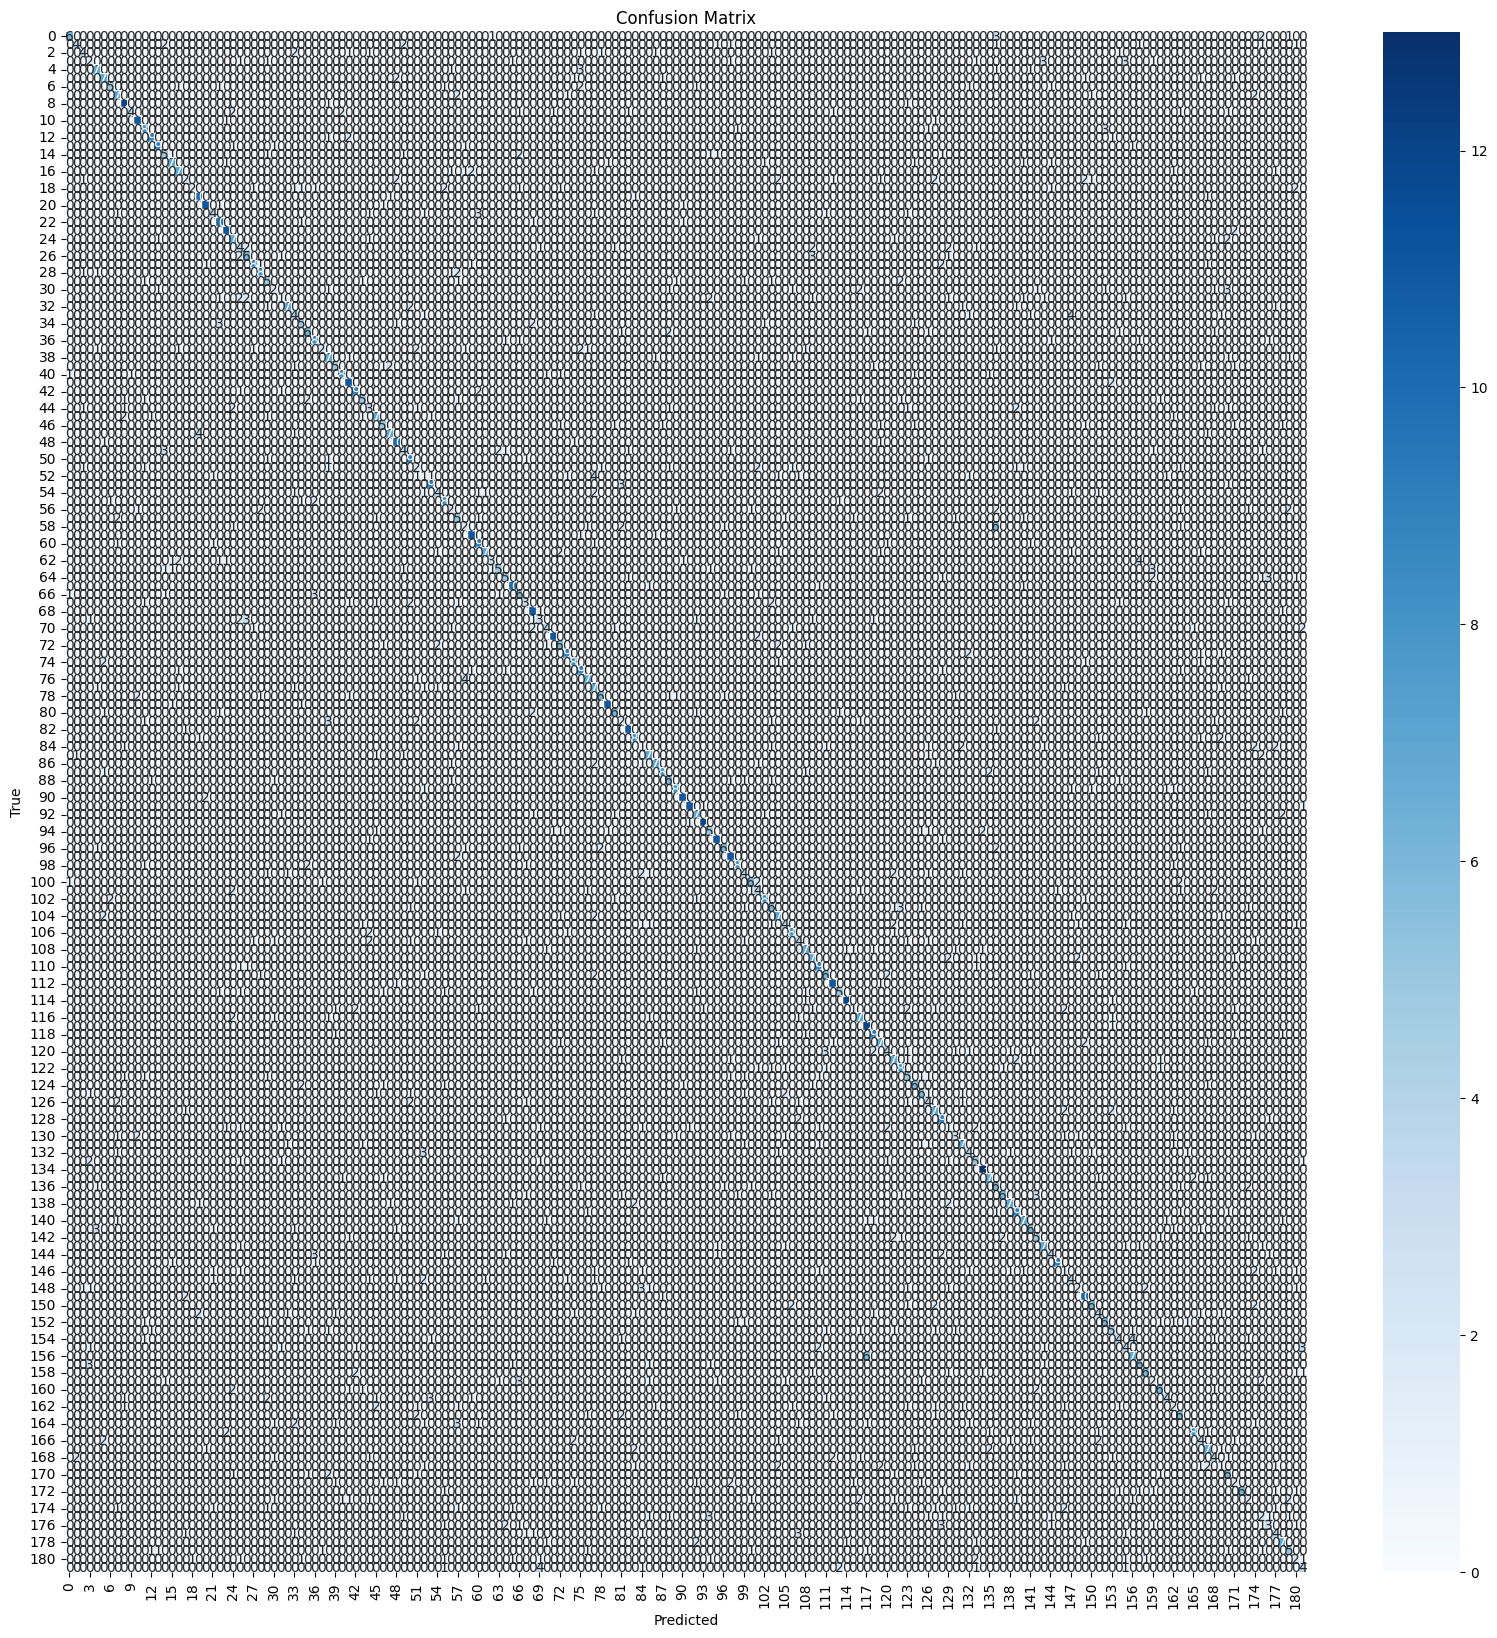

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report, balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Load the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Extract features (RGB values) and normalize to [0, 1]
y = data.iloc[:, -1].values  # Extract target variable (emotion labels)

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Perform feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))

# Define expanded parameter space for RandomizedSearchCV
param_distributions = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'max_depth': [int(x) for x in np.linspace(5, 50, num=10)] + [None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', class_weights],
    'max_leaf_nodes': [int(x) for x in np.linspace(start=10, stop=1000, num=10)] + [None]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV with Stratified K-Fold
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

# Perform Randomized Search
print("Performing Randomized Search for Random Forest...")
random_search.fit(X_train_selected, y_train)

# Print best parameters and scores
print("\nBest parameters for Random Forest:", random_search.best_params_)
print("Best cross-validation score for Random Forest:", random_search.best_score_)

# Get the best model
best_rf = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)

print("\nTest Set Results:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Print detailed classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

print("\nClassification Report:")
for i, label in enumerate(le.classes_):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# Check for overfitting/underfitting
train_score = best_rf.score(X_train_selected, y_train)
test_score = best_rf.score(X_test_selected, y_test)

print("\nModel Performance:")
print(f"Training set score: {train_score:.4f}")
print(f"Test set score: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("The model might still be overfitting, but less severely than before.")
elif test_score - train_score > 0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

# Feature importance analysis
feature_importance = best_rf.feature_importances_
feature_names = data.columns[:-1]  # Get feature names (exclude the target column)

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_train_selected.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_selected.shape[1]), feature_importance[indices])
plt.xticks(range(X_train_selected.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Lastly approach ! Same with the above but use GridSearch , early-stopping , cross-validation for feature selection

In [ ]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating visualizations
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score  # For model selection and evaluation
from sklearn.ensemble import RandomForestClassifier  # The main algorithm we're using
from sklearn.metrics import accuracy_score, log_loss, f1_score, classification_report, balanced_accuracy_score  # For model evaluation
from sklearn.feature_selection import SelectFromModel, RFECV  # For feature selection
from sklearn.preprocessing import LabelEncoder  # For encoding categorical labels
from sklearn.base import BaseEstimator, ClassifierMixin  # For creating custom estimator
import seaborn as sns  # For enhanced visualizations
from sklearn.exceptions import NotFittedError  # For handling errors

# Custom Random Forest Classifier with Early Stopping
class EarlyStoppingRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, **kwargs):
        self.n_estimators = n_estimators
        self.rf = RandomForestClassifier(warm_start=True, n_estimators=1, **kwargs)
        self.scores = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        # Implement early stopping
        for i in range(1, self.n_estimators + 1):
            self.rf.n_estimators = i
            self.rf.fit(X, y)
            if X_val is not None and y_val is not None:
                score = balanced_accuracy_score(y_val, self.rf.predict(X_val))
                self.scores.append(score)
                # Stop if performance doesn't improve for 5 iterations
                if i > 5 and score < np.mean(self.scores[-6:-1]):
                    break
        return self
    
    def predict(self, X):
        return self.rf.predict(X)
    
    def predict_proba(self, X):
        return self.rf.predict_proba(X)

# We create a custom Random Forest classifier that implements early stopping.
# This helps prevent overfitting by stopping the training process when the model's performance
# on a validation set stops improving. We use this instead of the standard RandomForestClassifier
# because scikit-learn's implementation doesn't have built-in early stopping.

# Load and preprocess the dataset
data = pd.read_csv('final_dataset_2.csv')
X = data.iloc[:, :-1].values / 255.0  # Extract features and normalize to [0, 1]
y = data.iloc[:, -1].values  # Extract target variable

# We load the data and normalize the feature values to be between 0 and 1.
# This is important for RGB values, as it brings all features to the same scale.

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# We use LabelEncoder to convert string labels to numeric values.
# This is necessary because many machine learning algorithms, including Random Forest,
# require numeric input.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# We split the data into training and testing sets. We use stratified sampling
# to ensure that the class distribution is preserved in both sets. This is crucial for
# imbalanced datasets to ensure that the model is evaluated on a representative sample.

# Cross-validated feature selection
def select_features_cv(X, y, estimator, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    selector = RFECV(estimator=estimator, step=1, cv=skf, scoring='balanced_accuracy', n_jobs=-1)
    selector = selector.fit(X, y)
    return selector

# We use Recursive Feature Elimination with Cross-Validation (RFECV) for feature selection.
# This method recursively removes features and uses cross-validation to select the best feature subset.
# We use this instead of simpler methods because it provides a more robust selection, especially
# for datasets with many features.

base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = select_features_cv(X_train, y_train, base_rf)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# We apply the feature selection to our training and test sets. This reduces
# the dimensionality of our data, which can improve model performance and reduce overfitting.

# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))

# We calculate class weights to handle class imbalance. This gives more importance
# to underrepresented classes during training, helping the model to perform well across all classes.

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', class_weights]
}

# We define a grid of hyperparameters to search over. This allows us to find
# the best combination of parameters for our model. We include a range of values for each
# parameter to explore different model complexities.

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=EarlyStoppingRandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

# We use GridSearchCV to perform an exhaustive search over the specified parameter grid.
# We use stratified k-fold cross-validation to ensure each fold is representative of the whole dataset.
# We use balanced accuracy as the scoring metric to handle potential class imbalance.

# Perform Grid Search
print("Performing Grid Search for Random Forest...")
grid_search.fit(X_train_selected, y_train)

# This step performs the actual grid search, fitting models with all combinations
# of parameters and selecting the best one based on cross-validation performance.

# Print best parameters and scores
print("\nBest parameters for Random Forest:", grid_search.best_params_)
print("Best cross-validation score for Random Forest:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf.predict(X_test_selected)
y_pred_proba = best_rf.predict_proba(X_test_selected)

print("\nTest Set Results:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# We evaluate the best model on the test set using multiple metrics.
# This gives us a comprehensive view of the model's performance, including its ability
# to handle class imbalance (balanced accuracy) and its overall predictive power (F1-score).

# Print detailed classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

print("\nClassification Report:")
for i, label in enumerate(le.classes_):
    print(f"{label}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")
    print()

# We print a detailed classification report for each class. This helps us
# understand how well the model performs for each emotion, which is crucial for
# identifying any classes that the model struggles with.

# Check for overfitting/underfitting
train_score = balanced_accuracy_score(y_train, best_rf.predict(X_train_selected))
test_score = balanced_accuracy_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Training set score: {train_score:.4f}")
print(f"Test set score: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("The model might still be overfitting, but less severely than before.")
elif test_score - train_score > 0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")

# We compare the model's performance on the training and test sets to check
# for overfitting or underfitting. This helps us understand if our model generalizes well
# to unseen data.

# Feature importance analysis
feature_importance = best_rf.rf.feature_importances_
selected_features = selector.support_
feature_names = data.columns[:-1][selected_features]

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_train_selected.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_selected.shape[1]), feature_importance[indices])
plt.xticks(range(X_train_selected.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# We analyze and visualize feature importances. This helps us understand
# which RGB values are most important for predicting emotions, providing insights into
# the relationship between colors and emotions.

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")

# We plot the learning curve to visualize how the model's performance changes
# with increasing amounts of training data. This helps us understand if the model would
# benefit from more data or if we're already at the point of diminishing returns.

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# We create a confusion matrix to visualize the model's predictions across
# all classes. This helps us identify which emotions are often confused with each other,
# providing insights into the model's strengths and weaknesses.